In [1]:
import sympy as sm
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import math
import bisect

sp.__version__

'1.10.1'

https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.make_interp_spline.html#scipy.interpolate.make_interp_spline

#### Лаба 1
#### Алгоритмы планирования траекторий

1. Генерация $\mathcal{C}^0$ гладкой траектории через 10 точек. 
2. Генерация $\mathcal{C}^1$ гладкой траектории
3. Генерация $\mathcal{C}^2$ гладкой траектории

#### Вариант 5

In [2]:
# Координаты точек:
gx = np.float32(np.array([15,5,7,9,18,13,2,-2,1,3]))
gy = np.float32(np.array([ 6,4,15,8,11,17,23,19,1,13]))
# coordinates = {'x':np.array(x), 'y':np.array(y)}

In [8]:
class CubicSpline1D:
    """
    1D Cubic Spline class

    Parameters
    ----------
    x : list
        x coordinates for data points. This x coordinates must be
        sorted
        in ascending order.
    y : list
        y coordinates for data points
    """

    def __init__(self, x, y):

        h = np.diff(x)
        if np.any(h < 0):
            raise ValueError("x coordinates must be sorted in ascending order")

        self.a, self.b, self.c, self.d = [], [], [], []
        self.x = x
        self.y = y
        self.nx = len(x)  # dimension of x

        # calc coefficient a
        self.a = [iy for iy in y]

        # calc coefficient c
        A = self.__calc_A(h)
        B = self.__calc_B(h, self.a)
        self.c = np.linalg.solve(A, B)

        # calc spline coefficient b and d
        for i in range(self.nx - 1):
            d = (self.c[i + 1] - self.c[i]) / (3.0 * h[i])
            b = 1.0 / h[i] * (self.a[i + 1] - self.a[i]) \
                - h[i] / 3.0 * (2.0 * self.c[i] + self.c[i + 1])
            self.d.append(d)
            self.b.append(b)

    def calc_position(self, x):
        """
        Calc `y` position for given `x`.

        if `x` is outside the data point's `x` range, return None.

        Returns
        -------
        y : float
            y position for given x.
        """
        if x < self.x[0]:
            return None
        elif x > self.x[-1]:
            return None

        i = self.__search_index(x)
        dx = x - self.x[i]
        position = self.a[i] + self.b[i] * dx + \
            self.c[i] * dx ** 2.0 + self.d[i] * dx ** 3.0

        return position

    def calc_first_derivative(self, x):
        """
        Calc first derivative at given x.

        if x is outside the input x, return None

        Returns
        -------
        dy : float
            first derivative for given x.
        """

        if x < self.x[0]:
            return None
        elif x > self.x[-1]:
            return None

        i = self.__search_index(x)
        dx = x - self.x[i]
        dy = self.b[i] + 2.0 * self.c[i] * dx + 3.0 * self.d[i] * dx ** 2.0
        return dy

    def calc_second_derivative(self, x):
        """
        Calc second derivative at given x.

        if x is outside the input x, return None

        Returns
        -------
        ddy : float
            second derivative for given x.
        """

        if x < self.x[0]:
            return None
        elif x > self.x[-1]:
            return None

        i = self.__search_index(x)
        dx = x - self.x[i]
        ddy = 2.0 * self.c[i] + 6.0 * self.d[i] * dx
        return ddy


    def __search_index(self, x):
        """
        search data segment index
        """
        return bisect.bisect(self.x, x) - 1

    def __calc_A(self, h):
        """
        calc matrix A for spline coefficient c
        """
        A = np.zeros((self.nx, self.nx))
        A[0, 0] = 1.0
        for i in range(self.nx - 1):
            if i != (self.nx - 2):
                A[i + 1, i + 1] = 2.0 * (h[i] + h[i + 1])
            A[i + 1, i] = h[i]
            A[i, i + 1] = h[i]

        A[0, 1] = 0.0
        A[self.nx - 1, self.nx - 2] = 0.0
        A[self.nx - 1, self.nx - 1] = 1.0
        return A

    def __calc_B(self, h, a):
        """
        calc matrix B for spline coefficient c
        """
        B = np.zeros(self.nx)
        for i in range(self.nx - 2):
            B[i + 1] = 3.0 * (a[i + 2] - a[i + 1]) / h[i + 1]\
                - 3.0 * (a[i + 1] - a[i]) / h[i]
        return B

class CubicSpline2D:
    """
    Cubic CubicSpline2D class

    Parameters
    ----------
    x : list
        x coordinates for data points.
    y : list
        y coordinates for data points.
    """

    def __init__(self, gx, gy, Rmax = 0.25, alpha=0.05):
        self.s = []
        self.sx = []
        self.sy = []
        x,y = self.__curvature_limits_spline(gx,gy,Rmax,alpha)
        self.x = x
        self.y = y


    def __no_curvature_limits_spline(self,x,y):
        self.s = self.__calc_s(x, y)
        self.sx = CubicSpline1D(self.s, x)
        self.sy = CubicSpline1D(self.s, y)
        return x,y
    
    def __curvature_limits_spline(self,x,y,Rmax,alpha):
        alpha = 0.05 # curvature changing speed in [%*0.01] 

        xnew = np.float32(np.array(range(len(x))))
        ynew = np.float32(np.array(range(len(x))))
        for i in range(len(x)):
            xnew[i] = x[i]
            ynew[i] = y[i]

        flag_good_curvature = 0
        while not flag_good_curvature:

            self.s = self.__calc_s(xnew, ynew)
            self.sx = CubicSpline1D(self.s, xnew)
            self.sy = CubicSpline1D(self.s, ynew)

            s = np.arange(0, self.s[-1], 0.1)

            # segments_counter = np.arange(1,len(x),1)
            # segments_length =  np.array(segments_counter)
            # for i in segments_counter:
            #     segments_length[i-1]=((x[i-1]-x[i])**2 + (y[i-1]-y[i])**2)**(1/2)
                
            flag_curvature_exceeded = 0
            for i_s in s:
                # print(self.calc_curvature(i_s))
                if abs(self.calc_curvature(i_s)) > (1/Rmax):
                    # print(self.calc_curvature(i_s))
                    # print(i_s)
                    for i in np.arange(1,len(x)-1,1):
                        # print([self.s[i-1]+(self.s[i]-self.s[i-1])/2, self.s[i]+(self.s[i+1]-self.s[i])/2])
                        if self.s[i-1]+(self.s[i]-self.s[i-1])/2 <= i_s <= self.s[i]+(self.s[i+1]-self.s[i])/2:
                            pi = np.array([ xnew[i] , ynew[i] ])
                            p4 = np.array([ (xnew[i-1]+xnew[i+1])/2 , (ynew[i-1]+ynew[i+1])/2 ])
                            p_new = pi + (p4-pi)*alpha
                            xnew[i] = p_new[0]
                            ynew[i] = p_new[1]
                            # print(p_new)
                            flag_curvature_exceeded = 1
                            break 
                
                if flag_curvature_exceeded:
                    break

            if not flag_curvature_exceeded:
                self.s = self.__calc_s(xnew, ynew)
                self.sx = CubicSpline1D(self.s, xnew)
                self.sy = CubicSpline1D(self.s, ynew)
                flag_good_curvature = 1

        return xnew,ynew

    def get_xy(self):
        return self.x,self.y

    def __calc_s(self, x, y):
        dx = np.diff(x)
        dy = np.diff(y)
        self.ds = np.hypot(dx, dy)
        s = [0]
        s.extend(np.cumsum(self.ds))
        return s

    def calc_position(self, s):
        """
        calc position

        Parameters
        ----------
        s : float
            distance from the start point. if `s` is outside the data point's
            range, return None.

        Returns
        -------
        x : float
            x position for given s.
        y : float
            y position for given s.
        """
        x = self.sx.calc_position(s)
        y = self.sy.calc_position(s)

        return x, y

    def calc_curvature(self, s):
        """
        calc curvature

        Parameters
        ----------
        s : float
            distance from the start point. if `s` is outside the data point's
            range, return None.

        Returns
        -------
        k : float
            curvature for given s.
        """
        dx = self.sx.calc_first_derivative(s)
        ddx = self.sx.calc_second_derivative(s)
        dy = self.sy.calc_first_derivative(s)
        ddy = self.sy.calc_second_derivative(s)
        k = (ddy * dx - ddx * dy) / ((dx ** 2 + dy ** 2)**(3 / 2))
        return k

    def calc_yaw(self, s):
        """
        calc yaw

        Parameters
        ----------
        s : float
            distance from the start point. if `s` is outside the data point's
            range, return None.

        Returns
        -------
        yaw : float
            yaw angle (tangent vector) for given s.
        """
        dx = self.sx.calc_first_derivative(s)
        dy = self.sy.calc_first_derivative(s)
        # if dy < 0:
        #     yaw = math.atan2(dy,dx) + 2*math.pi
        # else:
        yaw = math.atan2(dy,dx)
        return yaw

In [11]:
ds = 0.1  # [m] distance of each interpolated points
Rmax=1/2.15
sp = CubicSpline2D(gx, gy, Rmax, alpha=0.01)
# print(sp.s)
x_new,y_new = sp.get_xy()
s = np.arange(0, sp.s[-1], ds)
rx, ry, ryaw, rk = [], [], [], []

for i_s in s:
    ix, iy = sp.calc_position(i_s)
    rx.append(ix)
    ry.append(iy)
    ryaw.append(sp.calc_yaw(i_s))
    rk.append(sp.calc_curvature(i_s))

Text(0, 0.5, 'Curvature $\\xi,[1/m]$')

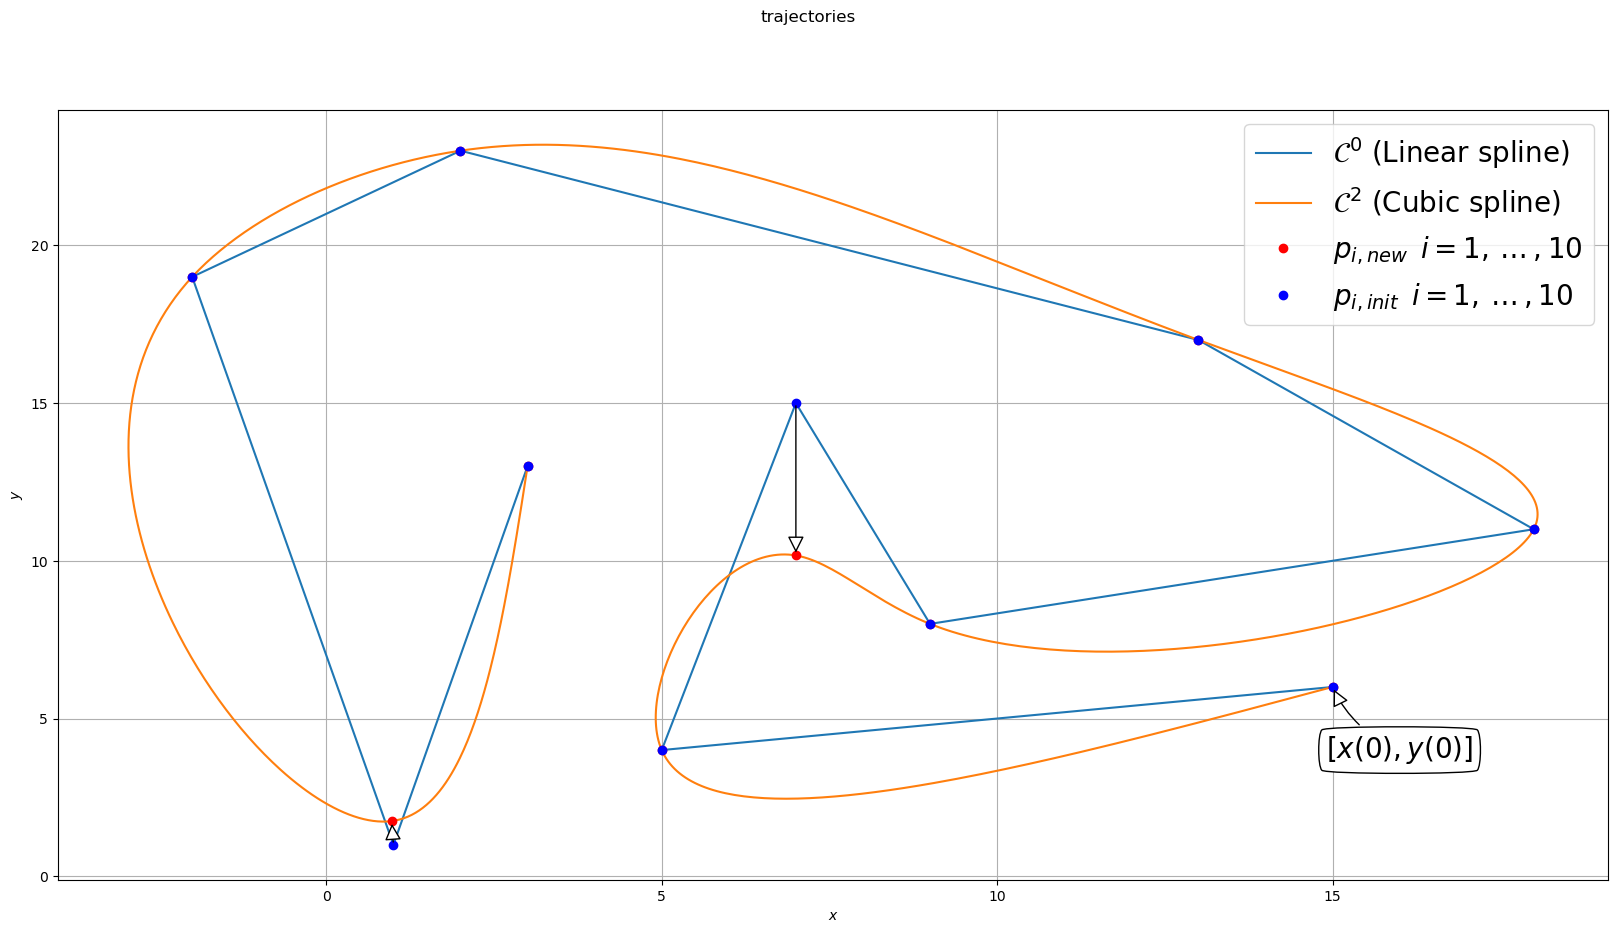

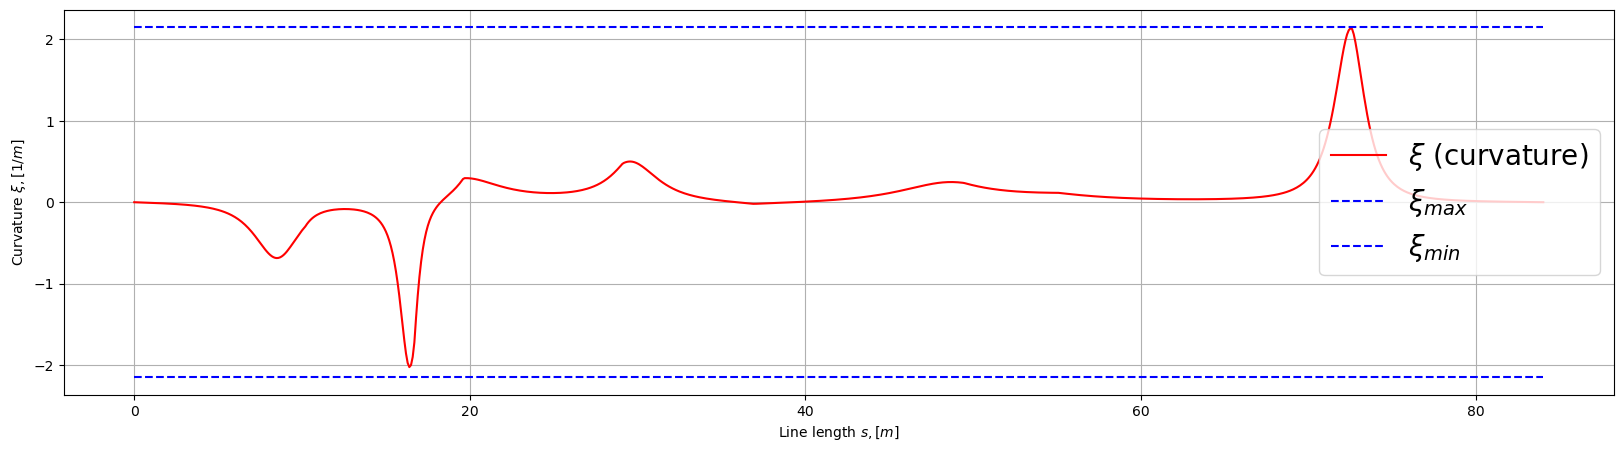

In [16]:

fig, ax = plt.subplots(1,1,figsize = (20,10))
ax = [ax, 1]
C0, = ax[0].plot(gx,gy)
C2, = ax[0].plot(rx, ry)

Points_new, = ax[0].plot(x_new, y_new, "or", label="Data points new")
Points_init, = ax[0].plot(gx, gy, "ob", label="Data points initial")

for x,y,xnew,ynew in zip(gx,gy,x_new,y_new):
    if not ( x == xnew and y == ynew ):
        ax[0].annotate("", xy=(xnew, ynew), xytext=(x,y),
            arrowprops=dict(arrowstyle="-|>",mutation_scale=25,fc="w"))

ax[0].annotate(rf'$[x(0),y(0)]$',
                  xy=(gx[0],gy[0]),
                  xytext=(gx[0]+1,gy[0]-2),
                  size=20, va="center", ha="center",
                  bbox=dict(boxstyle="round4", fc="w"),
                  arrowprops=dict(arrowstyle="-|>",mutation_scale=25,
                                  connectionstyle="arc3,rad=-0.2", fc="w"))
fig.suptitle("trajectories")
ax[0].set_xlabel("$x$")
ax[0].set_ylabel("$y$")
ax[0].grid(True)
ax[0].legend([C0,C2,Points_new,Points_init], ['$\mathcal{C}^0$ (Linear spline)','$\mathcal{C}^2 $ (Cubic spline)',
            '$p_{i,new}\,\,\,i=1,\dots,10$','$p_{i,init}\,\,\,i=1,\dots,10$'],fontsize="20")

plt.subplots(1,1,figsize = (20,5))
C1, = plt.plot(s, rk, "-r", label="curvature")
C2, = plt.plot(s, [1/Rmax]*len(s), "--b")
C3, = plt.plot(s, [-1/Rmax]*len(s), "--b")
plt.grid(True)
plt.legend([C1,C2,C3],['$\\xi$ (curvature)','$\\xi_{max}$','$\\xi_{min}$'],fontsize="20")
plt.xlabel("Line length $s,[m]$")
plt.ylabel("Curvature $\\xi,[1/m]$")

In [ ]:
plt.subplots(1)
plt.plot(s, [np.rad2deg(iyaw) for iyaw in ryaw], "-r", label="yaw")
plt.grid(True)
plt.legend()
plt.xlabel("line length[m]")
plt.ylabel("yaw angle[deg]")

$$S_j(x)=a_j+b_j(x-x_j)+c_j(x-x_j)^2$$
$$h_j=x_{j+1}-x_j$$
$$j=0,\dots,n-2$$
$N$ - number of points

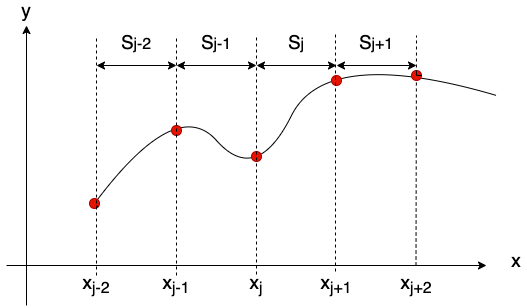

How to calculate the unknown parameters $a_j, b_j, c_j, d_j$:

Constarints:
1. $S_j(x_j)=y_j$
$$a_j=y_j$$
2. $S_j(x_{j+1})=S_{j+1}(x_{j+1})=y_{j+1}$
$$a_j+b_j h_j + c_j h_j^2 = a_{j+1} = y_{j+1}$$
$$b_j=\frac{1}{h_j} (a_{j+1}-a_j) - c_j h_j$$
3. $S'_j(x_{j+1})=S'_{j+1}(x_{j+1})$
$$S'_j(x)=b_j+2 c_j (x-x_j)$$
$$b_j + 2 c_j (x_{j+1}-x_j) = b_{j+1} $$
$$b_j + 2 c_j h_j = b_{j+1} $$
$$\frac{1}{h_j} (a_{j+1}-a_j) - c_j h_j + 2 c_j (x_{j+1}-x_j) = \frac{1}{h_{j+1}} (a_{j+2}-a_{j+1}) - c_{j+1} h_{j+1} $$
$$ c_j h_j + c_{j+1} h_{j+1} = \frac{1}{h_{j+1}} (a_{j+2}-a_{j+1}) - \frac{1}{h_j} (a_{j+1}-a_j) $$

<!-- 4. $S'_{0}(x_{0}) = 4  $
$$ S'_{0}(x_{0}) = b_0 = 4 $$
$$ b_0= \frac{1}{h_0} (a_{1}-a_0) - c_0 h_0 $$
$$ c_0 = \frac{ \frac{1}{h_0} (a_{1}-a_0) - b_0}{h_0} $$
$$ c_0 = \frac{ (a_{1}-a_0) - b_0 h_0}{h_0^2} $$
$$ c_0 = \frac{ (a_{1}-a_0) - 4 h_0}{h_0^2} $$

$$ b_0 + 2 c_0 h_0 = b_{1} $$
$$ 4 + 2 c_0 h_0 = b_{1} $$

$$ b_1 + 2 c_1 h_1 = b_{2} $$
$$ 2 c_1 h_1 = \frac{1}{h_2} (a_{3}-a_2) - c_2 h_2 - b_1 $$
$$ c_1 2 h_1 + c_2 h_2 = \frac{1}{h_2} (a_{3}-a_2) - 4 - 2 c_0 h_0 $$
$$ c_0 2 h_0 + c_1 2 h_1 + c_2 h_2 = \frac{1}{h_2} (a_{3}-a_2) - S'_{0}(x_{0}) $$ -->

<!-- 4. $S'_{n-1}(x_{n})=S'_{n}(x_{n})=4$
$$ b_{n-1} + 2 c_{n-1} (x_n-x_{n-1}) = 4 $$
$$ c_{n-1}= \frac{4}{2 h_{n-1}} - \frac{b_{n-1}}{2 h_{n-1}} = \frac{2}{h_{n-1}} - \frac{\frac{1}{h_{n-1}} (a_{n}-a_{n-1}) - c_{n-1} h_{n-1}}{2 h_{n-1}}$$
$$ c_{n-1} \frac{1}{2}  =  \frac{2}{h_{n-1}} - \frac{ (a_{n}-a_{n-1}) }{2 h_{n-1}^2} $$
$$ c_{n-1}  =  \frac{4}{h_{n-1}} - \frac{ (a_{n}-a_{n-1}) }{h_{n-1}^2} $$ -->

In [90]:
class QuadraticSpline1D:
    """
    1D Quadratic Spline class

    Parameters
    ----------
    x : list
        x coordinates for data points. This x coordinates must be
        sorted
        in ascending order.
    y : list
        y coordinates for data points
    """

    def __init__(self, x, y):
        
        h = np.diff(x)
        if np.any(h < 0):
            raise ValueError("x coordinates must be sorted in ascending order")

        self.a, self.b, self.c = [], [], []
        self.x = x
        self.y = y
        self.nx = len(x)  # dimension of x

        # calc coefficient a
        self.a = [iy for iy in y]

        # calc coefficient c
        A = self.__calc_A(h)
        B = self.__calc_B(h, self.a)
        self.c = np.linalg.solve(A, B)

        # calc spline coefficient b and d
        for i in range(self.nx - 1):
            b = (1.0 / h[i]) * (self.a[i + 1] - self.a[i]) \
               - h[i] * self.c[i]
            self.b.append(b)

    def calc_position(self, x):
        """
        Calc `y` position for given `x`.

        if `x` is outside the data point's `x` range, return None.

        Returns
        -------
        y : float
            y position for given x.
        """
        if x < self.x[0]:
            return None
        elif x > self.x[-1]:
            return None

        i = self.__search_index(x)
        dx = x - self.x[i]
        position = self.a[i] + self.b[i] * dx + \
            self.c[i] * dx ** 2.0

        return position

    def calc_first_derivative(self, x):
        """
        Calc first derivative at given x.

        if x is outside the input x, return None

        Returns
        -------
        dy : float
            first derivative for given x.
        """

        if x < self.x[0]:
            return None
        elif x > self.x[-1]:
            return None

        i = self.__search_index(x)
        dx = x - self.x[i]
        dy = self.b[i] + 2.0 * self.c[i] * dx
        return dy

    def calc_second_derivative(self, x):
        """
        Calc second derivative at given x.

        if x is outside the input x, return None

        Returns
        -------
        ddy : float
            second derivative for given x.
        """

        if x < self.x[0]:
            return None
        elif x > self.x[-1]:
            return None

        i = self.__search_index(x)
        ddy = 2.0 * self.c[i]
        return ddy


    def __search_index(self, x):
        """
        search data segment index
        """
        return bisect.bisect(self.x, x) - 1

    def __calc_A(self, h):
        """
        calc matrix A for spline coefficient c
        """
        A = np.zeros((self.nx, self.nx))

        # A[0,0] = 1 
        # A[1,1] = 2 * h[0]
        # A[1,2] = 2 * h[1]
        # A[1,3] = h[2]
        for i in range(self.nx - 1):
            if i != (self.nx - 2):
                A[i, i + 1] = h[i+1]
            A[i, i] = h[i]

        A[self.nx - 1, self.nx - 1] = 1.0
        return A

    def __calc_B(self, h, a):
        """
        calc matrix B for spline coefficient c
        """
        B = np.zeros(self.nx)
        # B[0] = (a[1] - a[0] - 4*h[0]) / ( h[0]**2)
        # B[1] = (a[3] - a[2]) / ( h[2]) + 4
        for i in range(self.nx - 2):
            B[i] = (a[i + 2] - a[i + 1]) / ( h[i + 1]) \
                - (a[i + 1] - a[i]) / ( h[i])
        # B[self.nx-2] = (4/h[self.nx-2]) - (a[self.nx-1]- a[self.nx-2])/( h[self.nx-2]**2  )
        return B

class QuadraticSpline2D:
    """
    Quadratic QuadraticSpline2D class

    Parameters
    ----------
    x : list
        x coordinates for data points.
    y : list
        y coordinates for data points.
    """

    def __init__(self, gx, gy, Rmax = 0.25, alpha=0.05):
        self.s = []
        self.sx = []
        self.sy = []
        x,y = self.__curvature_limits_spline(gx,gy,Rmax,alpha)
        self.x = x
        self.y = y


    def __no_curvature_limits_spline(self,x,y,Rmax,alpha):
        self.s = self.__calc_s(x, y)
        self.sx = QuadraticSpline1D(self.s, x)
        self.sy = QuadraticSpline1D(self.s, y)
        return x,y
    
    def __curvature_limits_spline(self,x,y,Rmax,alpha):
        alpha = 0.05 # curvature changing speed in [%*0.01] 

        xnew = np.float32(np.array(range(len(x))))
        ynew = np.float32(np.array(range(len(x))))
        for i in range(len(x)):
            xnew[i] = x[i]
            ynew[i] = y[i]

        flag_good_curvature = 0
        while not flag_good_curvature:

            self.s = self.__calc_s(xnew, ynew)
            self.sx = QuadraticSpline1D(self.s, xnew)
            self.sy = QuadraticSpline1D(self.s, ynew)

            s = np.arange(0, self.s[-1], 0.1)

            # segments_counter = np.arange(1,len(x),1)
            # segments_length =  np.array(segments_counter)
            # for i in segments_counter:
            #     segments_length[i-1]=((x[i-1]-x[i])**2 + (y[i-1]-y[i])**2)**(1/2)
                
            flag_curvature_exceeded = 0
            for i_s in s:
                # print(self.calc_curvature(i_s))
                if abs(self.calc_curvature(i_s)) > (1/Rmax):
                    # print(self.calc_curvature(i_s))
                    # print(i_s)
                    for i in np.arange(1,len(x)-1,1):
                        # print([self.s[i-1]+(self.s[i]-self.s[i-1])/2, self.s[i]+(self.s[i+1]-self.s[i])/2])
                        if self.s[i-1]+(self.s[i]-self.s[i-1])/2 <= i_s <= self.s[i]+(self.s[i+1]-self.s[i])/2:
                            pi = np.array([ xnew[i] , ynew[i] ])
                            p4 = np.array([ (xnew[i-1]+xnew[i+1])/2 , (ynew[i-1]+ynew[i+1])/2 ])
                            p_new = pi + (p4-pi)*alpha
                            xnew[i] = p_new[0]
                            ynew[i] = p_new[1]
                            # print(p_new)
                            flag_curvature_exceeded = 1
                            break 
                
                if flag_curvature_exceeded:
                    break

            if not flag_curvature_exceeded:
                self.s = self.__calc_s(xnew, ynew)
                self.sx = QuadraticSpline1D(self.s, xnew)
                self.sy = QuadraticSpline1D(self.s, ynew)
                flag_good_curvature = 1

        return xnew,ynew

    def get_xy(self):
        return self.x,self.y

    def __calc_s(self, x, y):
        dx = np.diff(x)
        dy = np.diff(y)
        self.ds = np.hypot(dx, dy)
        s = [0]
        s.extend(np.cumsum(self.ds))
        return s

    def calc_position(self, s):
        """
        calc position

        Parameters
        ----------
        s : float
            distance from the start point. if `s` is outside the data point's
            range, return None.

        Returns
        -------
        x : float
            x position for given s.
        y : float
            y position for given s.
        """
        x = self.sx.calc_position(s)
        y = self.sy.calc_position(s)

        return x, y

    def calc_curvature(self, s):
        """
        calc curvature

        Parameters
        ----------
        s : float
            distance from the start point. if `s` is outside the data point's
            range, return None.

        Returns
        -------
        k : float
            curvature for given s.
        """
        dx = self.sx.calc_first_derivative(s)
        ddx = self.sx.calc_second_derivative(s)
        dy = self.sy.calc_first_derivative(s)
        ddy = self.sy.calc_second_derivative(s)
        k = (ddy * dx - ddx * dy) / ((dx ** 2 + dy ** 2)**(3 / 2))
        return k

    def calc_yaw(self, s):
        """
        calc yaw

        Parameters
        ----------
        s : float
            distance from the start point. if `s` is outside the data point's
            range, return None.

        Returns
        -------
        yaw : float
            yaw angle (tangent vector) for given s.
        """
        dx = self.sx.calc_first_derivative(s)
        dy = self.sy.calc_first_derivative(s)
        # if dy < 0:
        #     yaw = math.atan2(dy,dx) + 2*math.pi
        # else:
        yaw = math.atan2(dy,dx)
        return yaw

In [91]:
ds = 0.1  # [m] distance of each interpolated points
Rmax=1/4
spline = QuadraticSpline2D(gx, gy, Rmax, alpha=0.01)
# print(sp.s)
x_new,y_new = spline.get_xy()
s = np.arange(0, spline.s[-1], ds)
rx, ry, ryaw, rk = [], [], [], []

for i_s in s:
    ix, iy = spline.calc_position(i_s)
    rx.append(ix)
    ry.append(iy)
    ryaw.append(spline.calc_yaw(i_s))
    rk.append(spline.calc_curvature(i_s))

Text(0, 0.5, 'Curvature $\\xi,[1/m]$')

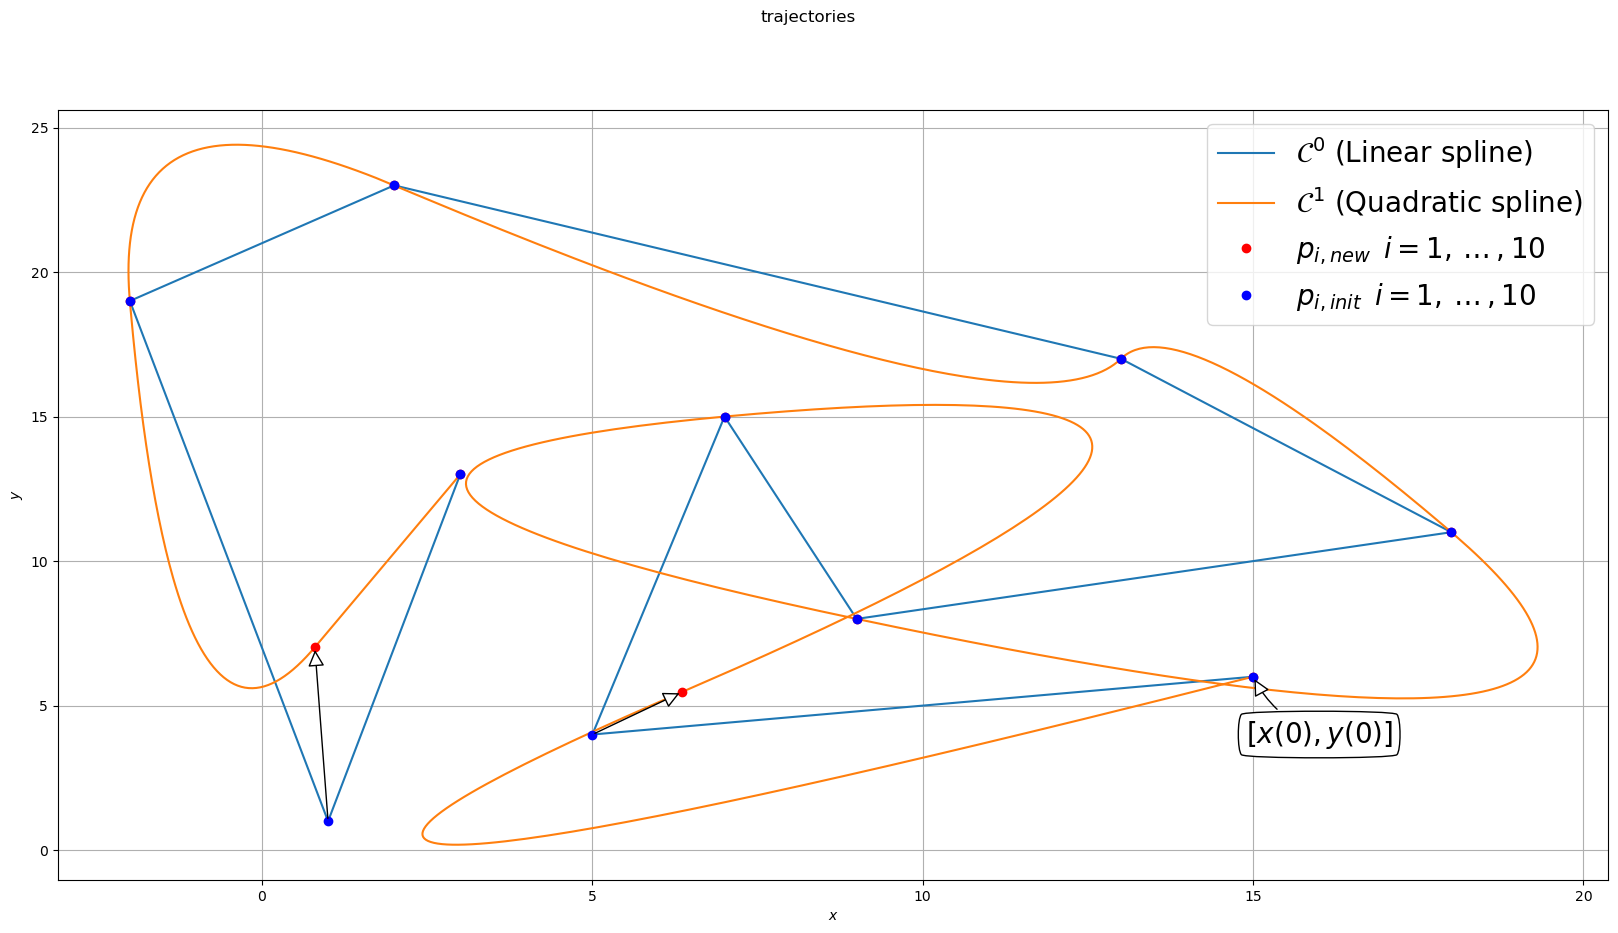

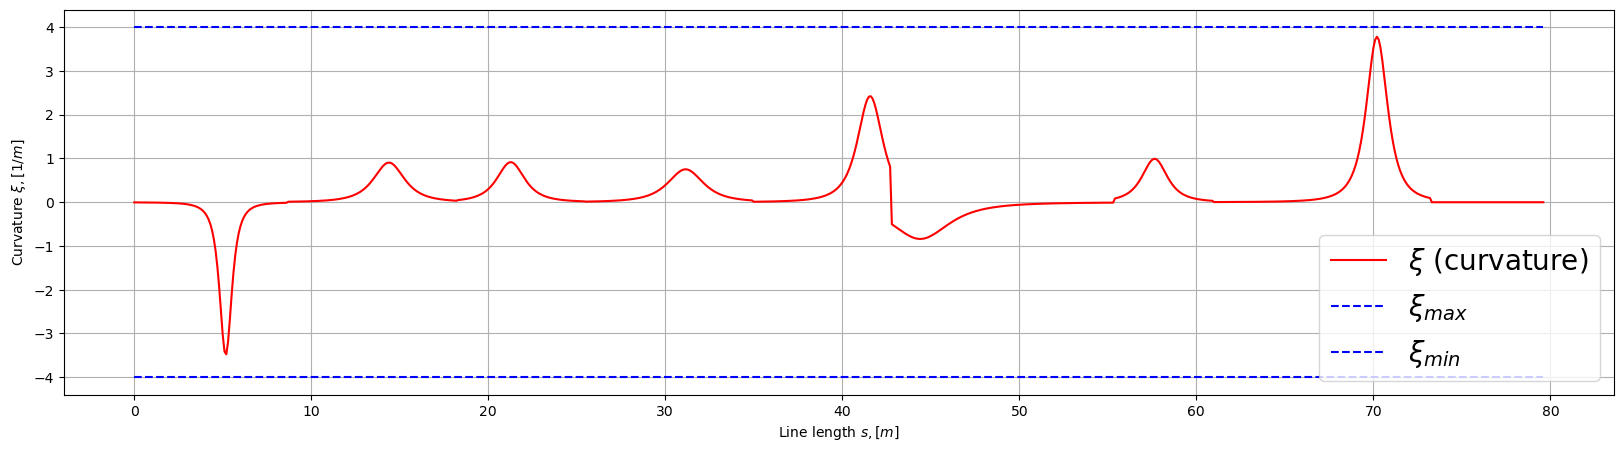

In [93]:
fig, ax = plt.subplots(1,1,figsize = (20,10))
ax = [ax, 1]
C0, = ax[0].plot(gx,gy)
C1, = ax[0].plot(rx, ry)

Points_new, = ax[0].plot(x_new, y_new, "or", label="Data points new")
Points_init, = ax[0].plot(gx, gy, "ob", label="Data points initial")

for x,y,xnew,ynew in zip(gx,gy,x_new,y_new):
    if not ( x == xnew and y == ynew ):
        ax[0].annotate("", xy=(xnew, ynew), xytext=(x,y),
            arrowprops=dict(arrowstyle="-|>",mutation_scale=25,fc="w"))

ax[0].annotate(rf'$[x(0),y(0)]$',
                  xy=(gx[0],gy[0]),
                  xytext=(gx[0]+1,gy[0]-2),
                  size=20, va="center", ha="center",
                  bbox=dict(boxstyle="round4", fc="w"),
                  arrowprops=dict(arrowstyle="-|>",mutation_scale=25,
                                  connectionstyle="arc3,rad=-0.2", fc="w"))
fig.suptitle("trajectories")
ax[0].set_xlabel("$x$")
ax[0].set_ylabel("$y$")
ax[0].grid(True)
ax[0].legend([C0,C1,Points_new,Points_init], ['$\mathcal{C}^0$ (Linear spline)','$\mathcal{C}^1 $ (Quadratic spline)',
            '$p_{i,new}\,\,\,i=1,\dots,10$','$p_{i,init}\,\,\,i=1,\dots,10$'],fontsize="20")

plt.subplots(1,1,figsize = (20,5))
C1, = plt.plot(s, rk, "-r", label="curvature")
C2, = plt.plot(s, [1/Rmax]*len(s), "--b")
C3, = plt.plot(s, [-1/Rmax]*len(s), "--b")
plt.grid(True)
plt.legend([C1,C2,C3],['$\\xi$ (curvature)','$\\xi_{max}$','$\\xi_{min}$'],fontsize="20",loc='lower right')
plt.xlabel("Line length $s,[m]$")
plt.ylabel("Curvature $\\xi,[1/m]$")

Text(0, 0.5, 'yaw angle[deg]')

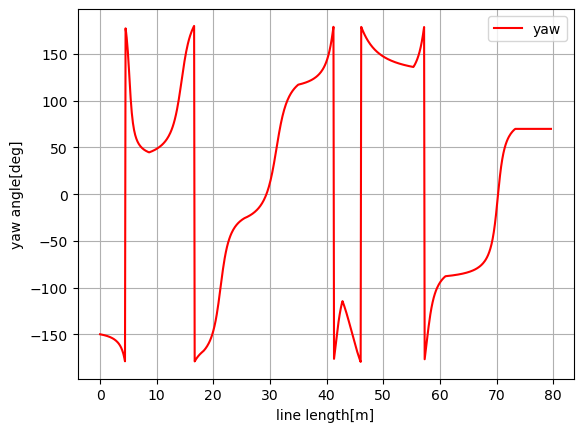

In [80]:
plt.subplots(1)
plt.plot(s, [np.rad2deg(iyaw) for iyaw in ryaw], "-r", label="yaw")
plt.grid(True)
plt.legend()
plt.xlabel("line length[m]")
plt.ylabel("yaw angle[deg]")